In [23]:
import larch
from larch.xafs import (pre_edge, autobk, sort_xafs, xftf, xftr, ff2chi, feffpath, feffit_transform, feffit_dataset, feffit, feffit_report, cauchy_wavelet)
from larch.fitting import param, guess, param_group
from larch.io import read_ascii
from larch.plot.plotly_xafsplots import (plot_mu, plot_bkg, plot_chik, plot_chir, plot_chiq, plot_chifit, multi_plot, plotlabels, set_label_weight)
import matplotlib.pyplot as plt

import larch.plot.plotly_xafsplots as lp
from larch.xafs import feffit
from larch.plot.plotly_xafsplots import *

import numpy as np
import os
import glob
import copy
%matplotlib widget

import plotly.graph_objects as go
from plotly.subplots import make_subplots

def color_gradient(c1,c2,mix=0): 
    import matplotlib as mpl
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)


def plot_traces(*figs):
    fig = go.Figure()
    for fig_i in figs:
        for trace_i in fig_i.traces:
            trace_i['line']['color'] = None
        fig.add_traces(fig_i.traces)
    # fig.show()
    return fig

    
def quad_plots(figs_E, figs_k=None, figs_R=None, figs_q=None, title=None):
    fig = make_subplots(rows=2, cols=2, subplot_titles=("Energy", "k-space", "R-space", "q-space"), horizontal_spacing=0.1, vertical_spacing=0.1)
    fig.update_layout(height=600, width=1000,title_text=title)

    for fig_i in figs_E.traces:
        fig.add_trace(fig_i, row=1, col=1)

    if figs_k is not None:
        for fig_i in figs_k.traces:
            fig.add_trace(fig_i, row=1, col=2)
    
    if figs_R is not None:
        for fig_i in figs_R.traces:
            fig.add_trace(fig_i, row=2, col=1)
    
    if figs_q is not None:
        for fig_i in figs_q.traces:
            fig.add_trace(fig_i, row=2, col=2)

    fig.show()
    return fig

def load_paths(feff_dir, amp_ratio=None, r_max=None, verbose=False):
    """
    Scan a FEFF run directory, filter by amp_ratio and r_max, and return
    a dict mapping 'path<index>' to the corresponding feffNNNN.dat filepath.

    If verbose=True, prints a table with:
      Path  Bond   Amp (%)  R_eff (Å)   Deg  Nlegs

    Parameters
    ----------
    feff_dir : str
        Directory containing list.dat and feffNNNN.dat files.
    amp_ratio : float or None
        Minimum curved‑wave amplitude ratio (%) to include.
    r_max : float or None
        Maximum effective path length (Å) to include.
    verbose : bool
        If True, print a summary table.

    Returns
    -------
    dict
        { 'path1': '…/feff0001.dat', 'path2': … }
    """
    list_file = os.path.join(feff_dir, "list.dat")
    if not os.path.isfile(list_file):
        raise FileNotFoundError(f"No list.dat found in {feff_dir}")

    # Read list.dat and locate table start
    lines = open(list_file).read().splitlines()
    start = next((i+1 for i, L in enumerate(lines) if "pathindex" in L.lower()), None)
    if start is None:
        start = next((i+1 for i, L in enumerate(lines) if L.strip().startswith("-----")), None)
    if start is None:
        raise ValueError("Couldn't find table in list.dat")

    # Parse columns: (index, amp, r_eff, deg, nlegs)
    entries = []
    for L in lines[start:]:
        parts = L.split()
        if not parts or not parts[0].isdigit():
            continue
        idx    = int(parts[0])
        amp    = float(parts[2])
        deg    = float(parts[3])
        nlegs  = int(parts[4])
        r_eff  = float(parts[5])
        entries.append((idx, amp, r_eff, deg, nlegs))

    # Apply filters
    sel = [
        (i, amp, r_eff, deg, nlegs)
        for (i, amp, r_eff, deg, nlegs) in entries
        if (amp_ratio is None or amp >= amp_ratio)
        and (r_max     is None or r_eff <= r_max)
    ]

    # Verbose header
    if verbose:
        header = f"{'Path':>4}  {'Bond':<7}  {'Amp (%)':>8}  {'R_eff (Å)':>9}  {'Deg':>4}  {'Nlegs':>5}"
        print(header)
        print('-' * len(header))

    paths = {}
    for idx, amp, r_eff, deg, nlegs in sel:
        # File path
        fname = os.path.join(feff_dir, f"feff{idx:04d}.dat")
        if not os.path.exists(fname):
            alt = fname.replace(".dat", ".data")
            if os.path.exists(alt):
                fname = alt
            else:
                continue

        # Determine bond type
        bond = ""
        with open(fname) as f:
            datlines = f.readlines()
        for j, line in enumerate(datlines):
            if "pot at#" in line.lower():
                atom_lines = [ln for ln in datlines[j+1:j+4] if ln.strip()]
                if len(atom_lines) >= 2:
                    el0 = atom_lines[0].split()[5]
                    el1 = atom_lines[1].split()[5]
                    bond = f"{el0}-{el1}"
                break

        # Print row
        if verbose:
            print(f"{idx:4d}  {bond:<7}  {amp:8.3f}  {r_eff:9.3f}  {deg:4.1f}  {nlegs:5d}")

        paths[f"path{idx}"] = fname

    return paths

# Batch analysis for 5 similar samples

## 1: load, normalize and get backgrounds

In [24]:
data = larch.io.read_athena(
                           'Ni_edges_athena_project_file.prj', 
                            match=None, 
                            do_preedge=True, # 
                            do_bkg=True, 
                            do_fft=True, 
                            use_hashkey=False
                            )



for label, grp in data.items():
    # get Athena’s energy shift (in eV), defaulting to 0.0 if missing
    es = getattr(grp, 'energy_shift', 0.0)
   #  print(es)
    # apply it to the energy axis
    grp.energy = grp.energy + es


In [25]:
data.keys()

['sam0307_1P_Ni_20250410_0655_uid_d8026657_e1e3_40f8_bcc9_5b4ecc2aeb20_csv',
 'trans_sam0307_1P_Ni_20250410_0655_uid_d8026657_e1e3_40f8_bcc9_5b4ecc2aeb20_csv',
 'trans_sam0307_1P_Ni_20250410_0655_uid_d8026657_e1e3_40f8_bcc9_5b4ecc2aeb20_csv_rebinned',
 'sam_0308_HE_Ni_merge',
 'trans_sam0308_merge',
 'trans_sam0308_merge_rebinned',
 'Ref_cycled_Ni_merge',
 'Ni_foil',
 'HE_cycled_Ni_merge']

### the dataset has 9 dataset, from now, we will only focus on one of the dataset: "Ni foil"

In [26]:
# Ni
datalist = [
 'Ni_foil',
 ]


## 2: do fourier transform and plot all

## pre-process experimental data, prepare for fitting

In [27]:
sam_all_figs = {key_i: {} for key_i in datalist}

# Parameters, please check the next cell to see what these parameters mean.
kmin = 3
kmax = 12
kweight = 2

dk = 1
rmin = 1
rmax = 3
rmax_out = 12
window = 'hanning'

for key_i in datalist:
    xftf(data[key_i], kmin=kmin, kmax=kmax, kweight=kweight, dk=dk, window=window, rmax_out=rmax_out)
    xftr(data[key_i], rmin=rmin, rmax=rmax, dr=0, window=window)

    sam_all_figs[key_i]['mu']   = plot_mu(data[key_i], show_norm=False, show_flat=False, show_e0=True, show_pre=True, show_post=True, label=f'mu_{key_i}')
    sam_all_figs[key_i]['chik'] = plot_chik(data[key_i], kweight=kweight, label=f'chik_{key_i}')
    sam_all_figs[key_i]['chir'] = plot_chir(data[key_i], label=f'chir_{key_i}', show_window=False)
    sam_all_figs[key_i]['chiq'] = plot_chiq(data[key_i], label=f'chiq_{key_i}', show_chik=False, show_window=False)

# Optional overlay plots
# plot_traces(sam_all_figs['PH_2']['chiq'], sam_all_figs['PH_3']['chiq'])

## compare all samples in in the subplots
This is just ploting, so far we are just doing the pre-processing:

1. substract a pre-edge background (red line in Fig.1), and mimic a post-edge background (green line)
2. subtract the oscillatory part of the spectrum, and convert the x-aixs from energy [eV] into wavenumber k[A-1]
3. Do a fourier transform, the parameter needed here is the window (shown in the red in Fig.2). Fig.3 shows the amplitude of the fourier transformed spectrum. now the X-axis is converted into R [A]. In this figure, we can clearly see different signals coming from the first-shell, second-shell contributions from the neighboring atoms
4. We can apply a window to Fig.3 to focus only on signals of e.g., the first-shell 1-3 A, then do fourier transoform back again. In order to distinguish, we use *q*-space instead of k-space, compared to Fig.2, you can see that the high-frequency component is gone. 

For the fitting process, we are actually fitting the Fig.4. 

In [28]:
for key_i in sam_all_figs.keys():
    quad_plots(figs_E=sam_all_figs[key_i]['mu'], 
               figs_k=sam_all_figs[key_i]['chik'],
               figs_R=sam_all_figs[key_i]['chir'],
               figs_q=sam_all_figs[key_i]['chiq'], title=key_i)

# Ni foil

the following cell will automatically look for the calculated FEFF paths, feff0001...0016.dat files in the defined folder 

In [36]:
Ni_paths = load_paths(
    feff_dir='FEFF_paths/Ni_foil/',
    amp_ratio=0, # this will filter out the paths below the amp_ratio, this is now set to 0, meaning all paths will be present
    r_max=5.5, # this will show the path up to 5.5 A 
    verbose=True
)

Path  Bond      Amp (%)  R_eff (Å)   Deg  Nlegs
-----------------------------------------------
   1  Ni-Ni     100.000      2.457  12.0      2
   2  Ni-Ni      22.740      3.475   6.0      2
   3  Ni-Ni      10.655      3.686  48.0      3
   4  Ni-Ni       9.737      4.195  48.0      3
   5  Ni-Ni      55.302      4.256  24.0      2
   6  Ni-Ni      10.851      4.585  48.0      3
   7  Ni-Ni      23.047      4.585  96.0      3
   8  Ni-Ni      19.059      4.915  12.0      2
   9  Ni-Ni       8.506      4.915  12.0      3
  10  Ni-Ni      50.060      4.915  24.0      3
  11  Ni-Ni      10.279      4.915  12.0      4
  12  Ni-Ni       3.960      4.915  12.0      4
  14  Ni-Ni      40.522      4.915  12.0      4
  15  Ni-Ni       3.198      4.915  48.0      4
  16  Ni-Ni       3.404      4.915  48.0      4
  17  Ni-Ni       4.650      5.094  48.0      3
  18  Ni-Ni       4.893      5.094  48.0      3


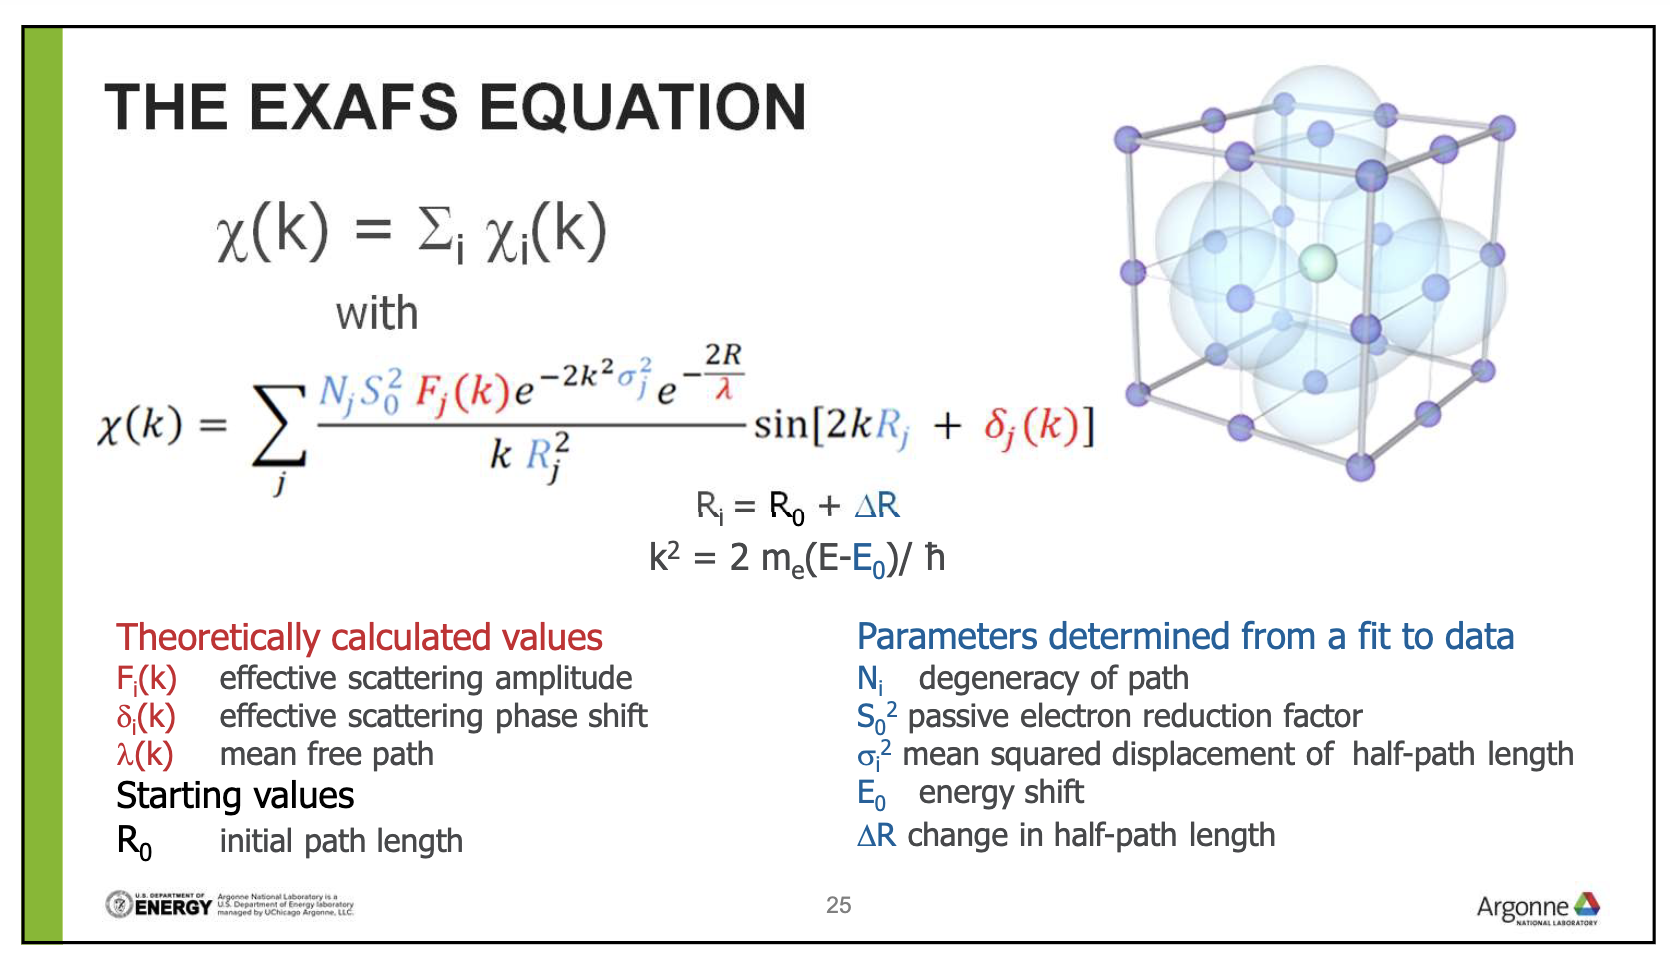

In [18]:
# we need to define different paths ...
# example is like this,
path1 = feffpath("FEFF_paths/Ni_foil/feff0001.dat",
                 degen='degen', # correspond to the N_i in the above slide
                 s02='amp', # correspond to the S02
                 e0='e0', 
                 deltar='deltar',
                 sigma2='sigma2'  # use Larch's built-in
                )


### since in this example, we want to fit all 16 paths, so I will do a for loop

In [29]:
from larch.xafs.sigma2_models import sigma2_eins

# --- Build all Ni_foil paths ---
Ni_foil_path_all = {}

# Inject built-in sigma2_eins from larch
# params._asteval.symtable['sigma2_eins'] = sigma2_eins

# Define FEFF paths with symbolic expression for sigma2
for path_key, path_str in Ni_paths.items():
    path = feffpath(path_str, # 0001, 0002, etc.
                    degen='degen',
                    s02='amp',
                    e0='e0',
                    deltar='alpha * reff',
                    sigma2='sigma2_4'  # use Larch's built-in
                   )
    
    # # Apply Einstein sigma²
    # s2 = sigma2_eins(t=300, theta=400, path=path)
    # print(s2)
    # path.sigma2 = s2
    Ni_foil_path_all[path_key] = path
    
Ni_foil_path_all['path1'].sigma2 = 'sigma2'
Ni_foil_path_all['path2'].sigma2 = 'sigma2_2'
Ni_foil_path_all['path3'].sigma2 = 'sigma2_2'

In [31]:
Ni_foil_path_all['path1']

Attribute,Type,Value
_calc_chi,method,>
calc_chi_from_params,method,>
create_path_params,method,>
create_spline_coefs,method,>
init_path_params,method,>
nleg,int,2
path_paramvals,method,>
pathpar_name,method,>
reff,float,2.4573
report,method,>


### once define all path and make variables for those fitting parameters
We need to guess the initial parameters

In [34]:
from larch.xafs import feffpath
from larch.fitting import group2params


# --- Define fitting parameters ---
params = param_group(
    amp=param(0.8, vary=True),
    e0=param(0.0, vary=True),
    alpha=param(0, vary=True),
    # t=param(300.0, vary=True),
    # theta=param(400.0, vary=True),
    sigma2=param(0.001, vary=True),
    sigma2_2=param(0.001, vary=True),
    sigma2_4=param(0.001, vary=True),
)

# --- Define fourier transform ---
trans = feffit_transform(kmin=3, kmax=13, 
                         rmin=1, rmax=5.0,
                         kweight=[1, 2, 3], dk=1, window='Hanning')

# define dataset (experimental data)
dset_Ni_foil = feffit_dataset(data=data['Ni_foil'], 
                              transform=trans, 
                              pathlist=Ni_foil_path_all)
sam_all_pathlist = {}
sam_all_pathlist['Ni_foil'] = Ni_foil_path_all

# --- Fit ---
result = feffit(params, [dset_Ni_foil])


In [35]:
# --- Print report ---
print(feffit_report(result, with_paths=True))

=================== FEFFIT RESULTS ====================
[[Statistics]]
  n_function_calls     = 64
  n_variables          = 6
  n_data_points        = 780
  n_independent        = 26.4647909
  chi_square           = 1941.82093
  reduced chi_square   = 94.8859403
  r-factor             = 0.00647658
  Akaike info crit     = 125.681262
  Bayesian info crit   = 133.336153
 
[[Variables]]
  alpha                =  0.0139543 +/- 0.0010541  (init= 0.0000000)
  amp                  =  0.9222755 +/- 0.0390770  (init= 0.8000000)
  e0                   = -6.6791944 +/- 0.4546802  (init= 0.0000000)
  sigma2               =  0.0066944 +/- 3.6000e-4  (init= 1.0000e-3)
  sigma2_2             =  0.0096556 +/- 0.0012506  (init= 1.0000e-3)
  sigma2_4             =  0.0088650 +/- 4.5094e-4  (init= 1.0000e-3)
 
[[Correlations]] (unreported correlations are <  0.100)
  alpha, e0            =  0.923
  amp, sigma2          =  0.883
  amp, sigma2_4        =  0.710
  sigma2, sigma2_4     =  0.628
  amp, sigma2

# plotting results

<Figure size 1000x500 with 0 Axes>

<Axes: >

Text(0.5, 0, '$k$ [$\\AA^{-1}$]')

Text(0, 0.5, '$k^2 \\chi (k)$ [$\\AA^{-2}$]')

(0.0, 9.5)

<Axes: >

Text(0.5, 1.0, 'Ni_foil')

Text(0.5, 0, '$R$ [$\\AA$]')

Text(0, 0.5, '$|\\chi(R)|$ [$\\AA ^{-3}$]')

(0.0, 5.0)

<Axes: >

Text(0.5, 0, '$R$ [$\\AA$]')

Text(0, 0.5, 'Re[$\\chi(R)$] [$\\AA ^{-3}$]')

(0.0, 5.0)

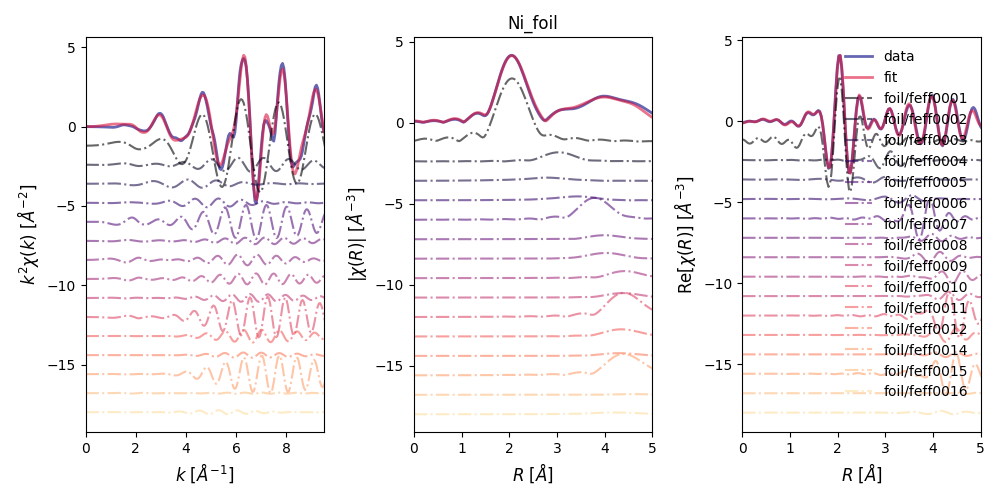

In [37]:
# colors = [xas.color_gradient("navy", 'crimson', i/3) for i in range(3)]
# colors = ['olive', 'orange', 'brown','k']
save_folder = '20240213_larch_figures/'
# cmap = plt.cm.nipy_spectral
cmap = plt.cm.magma
colors = [cmap(value) for value in np.linspace(0, 1, 16)]
usepath = 16

# step = 2.2 # Cu foil
kweight = 2
step = 1.2 * kweight / 2

kmax = 10
datalist = ['Ni_foil']


for i, sample in enumerate(datalist):
    plt.figure(figsize=(10,5))
    
    mod = result.datasets[i].model
    dat = result.datasets[i].data
    data_chik  = dat.chi * dat.k**kweight
    model_chik = mod.chi * mod.k**kweight

    plt.subplot(131)
    plt.plot(dat.k, data_chik, color='navy', label='data', alpha=0.6, lw=2)
    plt.plot(mod.k, model_chik, color='crimson', label='fit', alpha=0.6, lw=2)

    for i, path_i in enumerate(list(sam_all_pathlist[sample].values())[:usepath]):
        path_i_data = ff2chi([path_i], params=result.paramgroup)
        path_chik  = path_i_data.chi * path_i_data.k**kweight
        path_name = path_i.filename.split('_')[-1].split('.')[0]
        
        plt.plot(path_i_data.k,
                path_chik - step*(i+1),
                label=path_name, 
                color=colors[i], 
                alpha=0.6, lw=1.5, ls='-.')
        
    plt.xlabel("$k$ [$\\AA^{-1}$]", fontsize=12)
    plt.ylabel("$k^2 \\chi (k)$ [$\\AA^{-2}$]", fontsize=12)
    plt.xlim(0, 9.5)
    # plt.ylim(-4, 1.25)

    plt.subplot(132)
    xftf(dat, kmin=3, kmax=kmax, kweight=kweight, dk=1, window='hanning', rmax_out=12)
    xftf(mod, kmin=3, kmax=kmax, kweight=kweight, dk=1, window='hanning', rmax_out=12)

    plt.plot(dat.r, dat.chir_mag, color='navy', label='data', alpha=0.6, lw=2)
    plt.plot(mod.r, mod.chir_mag, color='crimson', label='fit', alpha=0.6, lw=2)

    for i, path_i in enumerate(list(sam_all_pathlist[sample].values())[:usepath]):
        path_i_data = ff2chi([path_i], params=result.paramgroup)
        path_chik  = path_i_data.chi * path_i_data.k**kweight
        xftf(path_i_data, kmin=3.5, kmax=9.5, kweight=kweight, dk=1, window='hanning', rmax_out=12)
        path_name = path_i.filename.split('_')[-1].split('.')[0]
        
        plt.plot(path_i_data.r,
                path_i_data.chir_mag - step*(i+1),
                label=path_name, 
                color=colors[i], 
                alpha=0.6, lw=1.5, ls='-.')
        
    plt.title(sample)
    plt.xlabel("$R$ [$\\AA$]", fontsize=12)
    plt.ylabel("$|\\chi(R)|$ [$\\AA ^{-3}$]", fontsize=12)
    plt.xlim(0, 5)
    # plt.ylim(-4, 1.25)

    plt.subplot(133)
    
    plt.plot(dat.r, dat.chir_re, color='navy', label='data', alpha=0.6, lw=2)
    plt.plot(mod.r, mod.chir_re, color='crimson', label='fit', alpha=0.6, lw=2)

    for i, path_i in enumerate(list(sam_all_pathlist[sample].values())[:usepath]):
        path_i_data = ff2chi([path_i], params=result.paramgroup)
        path_chik  = path_i_data.chi * path_i_data.k**kweight
        xftf(path_i_data, kmin=3.5, kmax=9.5, kweight=kweight, dk=1, window='hanning', rmax_out=12)
        path_name = path_i.filename.split('_')[-1].split('.')[0]
        
        plt.plot(path_i_data.r,
                path_i_data.chir_re - step*(i+1),
                label=path_name, 
                color=colors[i], 
                alpha=0.6, lw=1.5, ls='-.')
        
    plt.xlabel("$R$ [$\\AA$]", fontsize=12)
    plt.ylabel("Re[$\\chi(R)$] [$\\AA ^{-3}$]", fontsize=12)
    plt.xlim(0, 5)
    # plt.ylim(-4, 1.25)
    plt.legend(loc='upper right', frameon=False)
    plt.tight_layout();
    plt.savefig(sample + "all.jpg", dpi = 300);